In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline

In [2]:
class ConvCaps2D(nn.Module):
    def __init__(self):
        super(ConvCaps2D, self).__init__()
        # The paper suggests having 32 8D capsules
        self.capsules = nn.ModuleList([nn.Conv2d(in_channels = 256, out_channels = 8, kernel_size=(1,4), stride=2)
                                       for _ in range(32)])
        
    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm) # scale.size()  is (None, 1152, 1)  
        return scale*tensor / torch.sqrt(norm)
        
    def forward(self, x):
        outputs = [capsule(x).view(x.size(0), 8, -1) for capsule in self.capsules] # 32 list of (None, 1, 8, 36)
        outputs = torch.cat(outputs, dim = 2).permute(0, 2, 1)  # outputs.size() is (None, 1152, 8)
        return self.squash(outputs)

In [3]:
class Caps1D(nn.Module):
    def __init__(self):
        super(Caps1D, self).__init__()
        self.num_caps = 13
        self.num_iterations = 3
        self.W = nn.Parameter(torch.randn(13, 928, 8, 16))
        
    def softmax(self, x, dim = 1):
        transposed_input = x.transpose(dim, len(x.size()) - 1)
        softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)))
        return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(x.size()) - 1)

    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm)        
        return scale*tensor / torch.sqrt(norm)
   
    # Routing algorithm
    def forward(self, u):
        # u.size() is (None, 1152, 8)
        '''
        From documentation
        For example, if tensor1 is a j x 1 x n x m Tensor and tensor2 is a k x m x p Tensor, 
        out will be an j x k x n x p Tensor.
        
        We need j = None, 1, n = 1152, k = 10, m = 8, p = 16
        '''
        
        u_ji = torch.matmul(u[:, None, :, None, :], self.W) # u_ji.size() is (None, 10, 1152, 1, 16)
        
        b = Variable(torch.zeros(u_ji.size())) # b.size() is (None, 10, 1152, 1, 16)
        
        for i in range(self.num_iterations):
            c = self.softmax(b, dim=2)
            v = self.squash((c * u_ji).sum(dim=2, keepdim=True)) # v.size() is (None, 10, 1, 1, 16)

            if i != self.num_iterations - 1:
                delta_b = (u_ji * v).sum(dim=-1, keepdim=True)
                b = b + delta_b
        
        # Now we simply compute the length of the vectors and take the softmax to get probability.
        v = v.squeeze()
        classes = (v ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes) # This is not done in the paper, but I've done this to use CrossEntropyLoss.
        
        return classes
net = Caps1D()

In [4]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 256, kernel_size = (1,4), stride = 1)
        
        self.primaryCaps = ConvCaps2D()
        self.digitCaps = Caps1D()
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        
        return x

net = CapsNet()

In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [6]:
def evaluate(model, X, Y, batch_size = 200):
    results = []
    predicted = []
    for i in range(len(X)//batch_size):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = model(inputs)
        
        predicted += list(np.argmax(pred.data.cpu().numpy(), axis = 1))

    Y=Y[0:len(predicted)]
    acc = sum(Y == predicted)*1.0/(len(Y))  
    return acc

In [7]:
from livelossplot import PlotLosses
from sklearn.model_selection import train_test_split

In [8]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [9]:
##load the data and annotated cells 
data=pd.read_csv('lowdim_rna_prot_separated.csv',index_col=0)
label=np.genfromtxt('cell_type_no_onlyrna.csv',delimiter=',').astype('int64')

In [10]:
batch_size=200
trn_acc = []
tst_acc = []
trn_loss =[]
tst_loss=[]
#net=CapsNet()
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

d=X_train.values.reshape(len(X_train),1, 64, order='F')
d1_train=np.expand_dims(d.astype('float32'), 1)
        #l1_train=y_train
indices = np.random.permutation(len(d1_train))
d1_train=d1_train[indices]
l1_train=y_train[indices]

d1=X_val.values.reshape(len(X_val),1, 64, order='F')
d1_test=np.expand_dims(d1.astype('float32'), 1)
      # l1_test=y_test
indices = np.random.permutation(len(d1_test))
d1_test=d1_test[indices]
l1_test=y_val[indices]
liveloss = PlotLosses()


#logs = {}
loss_trn=[]
loss_test=[]
    #net1=net

for epoch in range(100):  # 500 epochs
    for phase in ['train', 'validation']:
        if phase == 'train':
            running_loss=0 
            for i in range(len(d1_train)//batch_size-1):    ##iteration
                print(i,)
                s = i*batch_size
                e = i*batch_size+batch_size

                inputs = torch.from_numpy(d1_train[s:e])
                labels = torch.LongTensor(np.array(l1_train[s:e]))

                    # wrap them in Variable
                inputs, labels = Variable(inputs), Variable(labels)

                    # zero the parameter gradients
                optimizer.zero_grad()

                    # forward + backward + optimize
                outputs = net(inputs)

                loss = criterion(outputs, labels)
                loss.backward()

                optimizer.step()
                running_loss += loss.data.item()
        #    print("Epoch, Loss - {}, {}".format(i, running_loss))
                del inputs, labels
                #print('\n')
               # trn_loss.append(running_loss)
        else: 
            r=random.sample(range(1, len(d1_train)), 1000)
            trn_acc.append(evaluate(net, d1_train[r], l1_train[r], batch_size = 200)) 
            tst_acc.append(evaluate(net, d1_test, l1_test, batch_size=200)) 
            out_train=net(torch.from_numpy(d1_train[r]))
            out_test=net(torch.from_numpy(d1_test))
            loss_trn = criterion(out_train, torch.LongTensor(np.array(l1_train[r])))
            loss_test= criterion(out_test, torch.LongTensor(np.array(l1_test)))
            trn_loss.append(loss_trn.data.item())
            tst_loss.append(loss_test.data.item())
            print("train_acc",trn_acc)
            print("test_acc",tst_acc)
            print("train_loss",trn_loss)
            print("test_acc",tst_loss)
            #logs['log_loss_trn'] = loss_trn.append(loss_trn)
        #logs['log_loss_tst'] = loss_test.append(loss_test)
        #logs['tr_accuracy'] = trn_acc[-1]
        #logs['tst_accuracy'] = tst_acc[-1]

    #liveloss.update(logs)
    #liveloss.draw()
    #print("Epoch, Loss - {}, {}".format(epoch, running_loss))
    #print("Train - ", trn_acc[-1])
    #print("Test - ", tst_acc[-1])

0


/export/scratch1/home/sumanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/export/scratch1/home/sumanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
train_acc [0.626]
test_acc [0.6278571428571429]
train_loss [2.5011682510375977]
test_acc [2.501864194869995]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
train_acc [0.626, 0.629]
test_acc [0.6278571428571429, 0.6371428571428571]
train_loss [2.5011682510375977, 2.494143009185791]
test_acc [2.501864194869995, 2.495025634765625]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
train_acc [0.626, 0.629, 0.768]
test_acc [0.6278571428571429, 0.6371428571428571, 0.7492857142857143]
train_loss [2.5011682510375977, 2.494143009185791, 2.486664295196533]
test_acc [2.501864194869995, 2.495025634765625, 2.4883968830108643]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
train_acc [0.626, 0.629, 0.768, 0.818]
test_acc [0.6278571428571429, 0.6371428571428571, 0.7492857142857143, 0.7735714285714286]
train_loss [2.5011682510375977, 2.494143009185791, 2.4866642951965

In [15]:
d=X_test.values.reshape(len(X_test),1, 64, order='F')
d1_test=np.expand_dims(d.astype('float32'), 1)
pred=net(Variable(torch.from_numpy(d1_test)))

/export/scratch1/home/sumanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/export/scratch1/home/sumanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [20]:
predicted=list(np.argmax(pred.data.cpu().numpy(), axis = 1))



In [21]:
from numpy import savetxt
savetxt('test_dataciteseq.csv', X_test, delimiter=',')
savetxt('test_data_predlabel.csv', predicted, delimiter=',')
savetxt('test_data_orglabel.csv', y_test, delimiter=',')

Text(0.5, 1.0, 'accuracy')

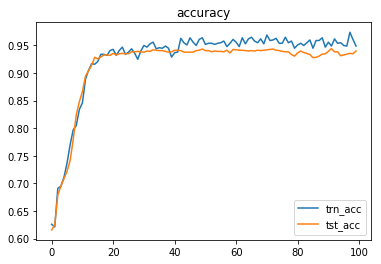

In [6]:
fig, ax = plt.subplots()
ax.plot(range(0,100), trn_acc, label = 'trn_acc')
ax.plot(range(0,100), tst_acc, label = 'tst_acc')
leg = ax.legend()
plt.title('accuracy')

In [9]:
from numpy import savetxt
savetxt('capsule_rnaprot_trnacc.csv', trn_acc, delimiter=',')
savetxt('capsule_rnaprot_tstacc.csv', tst_acc, delimiter=',')


Text(0.5, 1.0, 'loss')

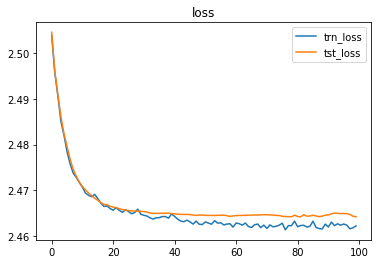

In [13]:
fig, ax = plt.subplots()
ax.plot(range(0,100),trn_loss,label='trn_loss')
ax.plot(range(0,100),tst_loss,label='tst_loss')
leg=ax.legend()
plt.title('loss')

In [14]:
test=X_test.values.reshape(len(X_test),1, 64, order='F')
test_sample_x=np.expand_dims(test.astype('float32'), 1)
test_sample_y=y_test
input_test = torch.from_numpy(test_sample_x)
input_labels = torch.LongTensor(np.array(test_sample_y))
outputs_test = net(input_test)
loss_test = criterion(outputs_test, input_labels)
test_acc=evaluate(net, test_sample_x, test_sample_y, batch_size = 200)

/export/scratch1/home/sumanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/export/scratch1/home/sumanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [15]:
max(tst_acc)

0.9442857142857143

In [ ]:
net


In [17]:
test_acc=evaluate(net, d1_test, l1_test, batch_size = 200)

/export/scratch1/home/sumanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/export/scratch1/home/sumanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [18]:
test_acc

0.94

In [19]:
l1_test.shape

(1421,)